<a href="https://colab.research.google.com/github/Min1222Ag/AISecApp/blob/main/Autoencoder_Mosaicking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras opencv-python-headless

In [2]:
from google.colab import drive
# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 이미지 경로 설정
training_images_path = '/content/drive/My Drive/Autoencoder_Mosaicking/data'  # 여기에 실제 이미지 경로를 입력하세요

In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 이미지 로드 함수
def load_images(image_path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(image_path):
        img = load_img(os.path.join(image_path, filename), target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)
    return np.array(images)

# 이미지 로드
images = load_images(training_images_path)


In [5]:
# 얼굴 검출을 위한 Haar Cascade 로드
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [6]:
# 얼굴에 모자이크 적용 함수
def apply_mosaic_to_faces(image, kernel_size=10):
    image_array = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi = image_array[y:y+h, x:x+w]
        roi = cv2.resize(roi, (w // kernel_size, h // kernel_size), interpolation=cv2.INTER_LINEAR)
        roi = cv2.resize(roi, (w, h), interpolation=cv2.INTER_NEAREST)
        image_array[y:y+h, x:x+w] = roi

    return image_array / 255.0

In [7]:
def add_mosaic_to_faces(images, kernel_size=10):
    mosaic_images = []
    for image in images:
        mosaic_image = apply_mosaic_to_faces(image, kernel_size)
        mosaic_images.append(mosaic_image)
    return np.array(mosaic_images)

In [8]:
# 얼굴에 모자이크를 적용한 이미지 준비
mosaic_images = add_mosaic_to_faces(images)

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [10]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [11]:
input_shape = (128, 128, 3)

# 얼굴에 모자이크를 씌우는 Autoencoder
mosaic_autoencoder = build_autoencoder(input_shape)

# 모자이크가 없는 원본 이미지를 복원하는 Autoencoder
restore_autoencoder = build_autoencoder(input_shape)

In [12]:
# 모델 학습
# 모자이크를 씌우는 모델 학습
mosaic_autoencoder.fit(images, mosaic_images, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# 복원 모델 학습
restore_autoencoder.fit(mosaic_images, images, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.6934 - val_loss: 0.6853
Epoch 2/50
1/1 [==============================] - 1s 799ms/step - loss: 0.6900 - val_loss: 0.6764
Epoch 3/50
1/1 [==============================] - 1s 822ms/step - loss: 0.6873 - val_loss: 0.6689
Epoch 4/50
1/1 [==============================] - 1s 785ms/step - loss: 0.6848 - val_loss: 0.6658
Epoch 5/50
1/1 [==============================] - 1s 782ms/step - loss: 0.6826 - val_loss: 0.6588
Epoch 6/50
1/1 [==============================] - 1s 766ms/step - loss: 0.6793 - val_loss: 0.6504
Epoch 7/50
1/1 [==============================] - 1s 801ms/step - loss: 0.6752 - val_loss: 0.6426
Epoch 8/50
1/1 [==============================] - 1s 767ms/step - loss: 0.6701 - val_loss: 0.6353
Epoch 9/50
1/1 [==============================] - 1s 776ms/step - loss: 0.6642 - val_loss: 0.6222
Epoch 10/50
1/1 [==============================] - 1s 784ms/step - loss: 0.6570 - val_loss: 0.6061
Epoch 11/50
1/1 [=====

1/1 [==============================] - 0s 131ms/step


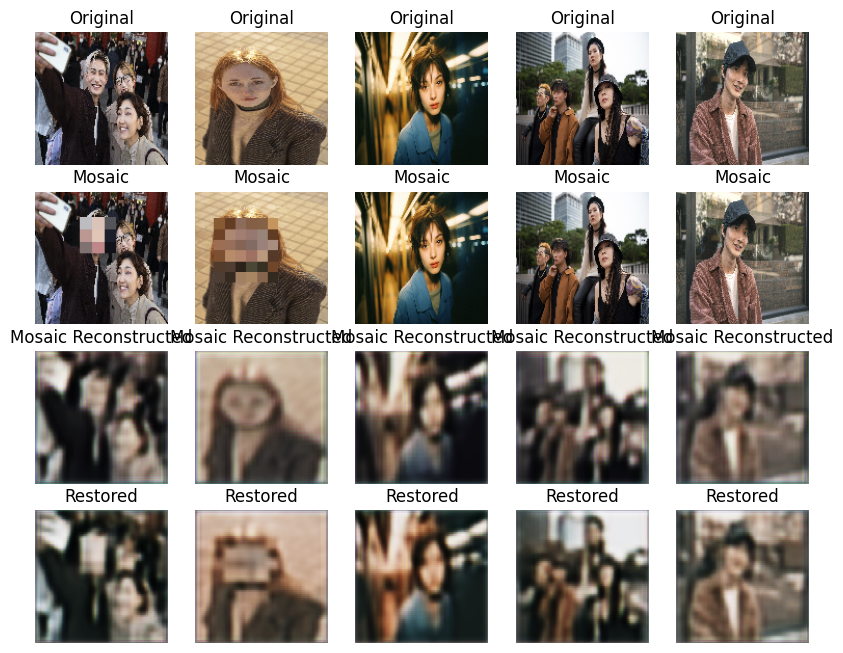

In [13]:
 import matplotlib.pyplot as plt
import random

# 학습 이미지 경로에서 랜덤하게 5개의 이미지 선택
random_training_images = random.sample(os.listdir(training_images_path), 5)

# 테스트 이미지 로드
test_images = []
for filename in random_training_images:
    img = load_img(os.path.join(training_images_path, filename), target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize
    test_images.append(img_array)
test_images = np.array(test_images)

# 선택된 테스트 이미지에 모자이크 적용
test_mosaic_images = add_mosaic_to_faces(test_images)

# 모자이크 적용 결과 확인
reconstructed_mosaic_images = mosaic_autoencoder.predict(test_images)
# 원본 복원 결과 확인
restored_images = restore_autoencoder.predict(test_mosaic_images)

# 결과 시각화
def plot_images(original, mosaic, reconstructed, restored, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # 원본 이미지
        ax = plt.subplot(5, num_images, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # 모자이크 이미지
        ax = plt.subplot(5, num_images, i + 1 + num_images)
        plt.imshow(mosaic[i])
        plt.title("Mosaic")
        plt.axis("off")

        # 모자이크 재건 이미지
        ax = plt.subplot(5, num_images, i + 1 + num_images * 2)
        plt.imshow(reconstructed[i])
        plt.title("Mosaic Reconstructed")
        plt.axis("off")

        # 복원 이미지
        ax = plt.subplot(5, num_images, i + 1 + num_images * 3)
        plt.imshow(restored[i])
        plt.title("Restored")
        plt.axis("off")

    plt.show()

plot_images(test_images, test_mosaic_images, reconstructed_mosaic_images, restored_images)
